# Evaluación de equidad por género

## Índice de Contenido

1. [Preparación del entorno y carga de datos](#1-Preparación-del-entorno-y-carga-de-datos)
2. [Mirando matriz de confusión y métricas varias](#2-Mirando-matriz-de-confusión-y-métricas-varias)
3. [Evaluando según distintos enfoques del Group Fairness](#4-Evaluando-según-distintos-enfoques-del-group-fairness)
    - [Definición de métricas del Group Fairness](#3.1-Definición-de-métricas-del-group-fairness)
    - [Evaluación de disparidad](#3.2-Evaluación-de-disparidad)
4. [Resumen y conclusiones](#4.-Resumen-y-conclusiones)

## 1. Preparación del entorno y carga de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

ruta_archivo = os.path.join('..', 'data', 'processed', 'df_genero_eval.csv')

df_genero_eval = pd.read_csv(ruta_archivo)

In [2]:
# Vista general de los datos
print(f"Dimensiones del dataset: {df_genero_eval.shape[0]} filas × {df_genero_eval.shape[1]} columnas\n")
print("Primeras 5 filas:")
df_genero_eval.head()

Dimensiones del dataset: 200 filas × 3 columnas

Primeras 5 filas:


,y_test,y_pred_test,genre
0,0,1,female
1,1,1,male
2,1,0,male
3,1,1,male
4,1,1,male


In [3]:
# Información general sobre el dataset
df_genero_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   y_test       200 non-null    int64 
 1   y_pred_test  200 non-null    int64 
 2   genre        200 non-null    object
dtypes: int64(2), object(1)
memory usage: 4.8+ KB


## 2. Mirando matriz de confusión y métricas varias

Ahora vamos a analizar al atributo que consideramos sensible en este análisis, el género. Para esto vamos a separar el conjunto de datos entre la categoría femenina y masculina:

In [4]:
df_male_eval = df_genero_eval[df_genero_eval['genre'] == 'male']
df_female_eval = df_genero_eval[df_genero_eval['genre']  == 'female']

Con los grupos separados lo siguiente es armar una matriz de confusión para cada uno, así podremos tener insights más precisos sobre el comportamiento del modelo con ambos grupos:

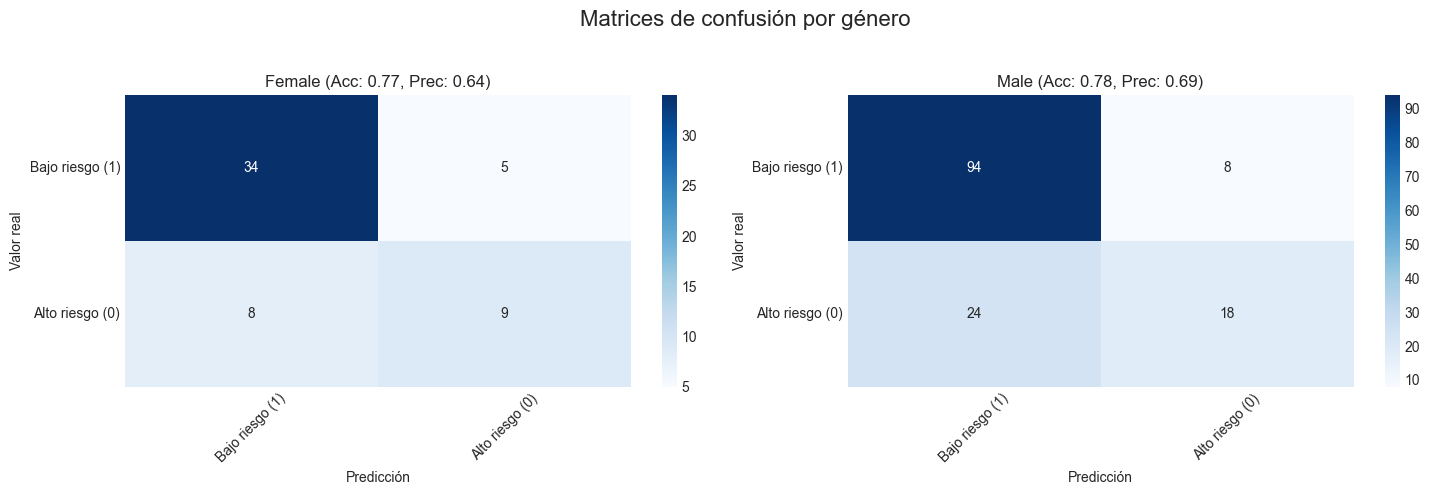

In [5]:
from tp_final_fairness_ML.utils.plotting import graficar_matriz_de_confusion_por_genero

graficar_matriz_de_confusion_por_genero([df_female_eval, df_male_eval], ['Bajo riesgo (1)', 'Alto riesgo (0)'], 'genre', 'y_test', 'y_pred_test')

De este par de gráficos podemos notar lo siguiente:

* En ambas categorías el modelo logró identificar en la mayoría de los casos a los verdaderos positivos con 34 casos en la categoría femenina y 94 en la masculina.

* En la categoría masculina se obtuvo una mayor tasa de falsos positivos en términos de proporción a comparación de la categoría femenina, siendo que de un total de 42 casos de alto riesgo, 24 fueron falsos positivos y 18 verdaderos negativos.

* En la categoría femenina solamente se identificaron a 5 personas erróneamente como de alto riesgo, lo que indica que el modelo tuvo un buen desempeño identificando instancias positivas en esta clase.

Con estos puntos ya empezamos a notar cosas importantes acerca del desempeño del modelo entre los grupos, pareciendo inicialmente que el modelo se desempeñó mejor en la clase femenina.

Miremos ahora las métricas generales de clasificación para cada grupo:

In [6]:
from sklearn.metrics import classification_report

print("Mujeres:")
print(classification_report(df_female_eval['y_test'], df_female_eval['y_pred_test']))
print("Hombres:")
print(classification_report(df_male_eval['y_test'], df_male_eval['y_pred_test']))

Mujeres:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58        17
           1       0.81      0.87      0.84        39

    accuracy                           0.77        56
   macro avg       0.73      0.70      0.71        56
weighted avg       0.76      0.77      0.76        56

Hombres:
              precision    recall  f1-score   support

           0       0.69      0.43      0.53        42
           1       0.80      0.92      0.85       102

    accuracy                           0.78       144
   macro avg       0.74      0.68      0.69       144
weighted avg       0.77      0.78      0.76       144



Podemos ver que en términos de métricas calculadas no hay diferencias significativas entre ambos géneros, siendo que en casos como **accuracy general** ambas tuvieron puntajes casi similares e igual ocurre con las otras métricas. **¿Que implica esto en términos de equidad?**.

Para analizar esto aún más a profundidad vamos a hacer **pruebas de disparidad** entre ambos géneros para evaluar si el modelo está generando predicciones justas.

## 3. Evaluando según distintos enfoques del Group Fairness

En el contexto en el que nos encontramos, donde desarrollamos un modelo de aprendizaje automático que ayude en la asignación de créditos bancarios, es fundamental garantizar que las decisiones del sistema no estén sesgadas en función de atributos sensibles como el género. Un enfoque que nos ayudará a evaluar cuestiones relacionadas al sesgo por grupos es el **Group Fairness (equidad grupal)**, el cual permite evaluar si el modelo trata de manera equitativa a distintos grupos poblacionales definidos por atributos sensibles. 

Este enfoque se basa en comparar métricas de desempeño del modelo **—como tasas de verdaderos positivos, falsos positivos, precisión o tasa de aprobación—** entre los distintos grupos. Su relevancia radica en que ayuda a identificar **disparidades sistemáticas que podrían derivar en discriminación algorítmica**, afectando la transparencia, la justicia y, potencialmente, el cumplimiento normativo de la organización.

### 3.1 Definición de métricas del Group Fairness

Entre las principales definiciones de equidad según el enfoque de **Group Fairness**, se identifican **cuatro métricas clave**, que en nuestro caso pueden interpretarse de la siguiente manera:

* **Statistical Parity / Demographic Parity (Independencia): $\mathbb{P}(\hat{Y} = 1 | A =a) = \mathbb{P}(\hat{Y} = 1 | A =b)$:** En nuestro contexto, la clase positiva (1) representa a un solicitante con bajo riesgo crediticio. Este criterio busca que la proporción de personas clasificadas por el modelo como de bajo riesgo sea la misma en ambos grupos (géneros). Esto apunta a garantizar un acceso equitativo a decisiones favorables sin importar el grupo al que se pertenezca.

* **Equalized Odds (Separación): $\mathbb{P}(\hat{Y} = 1 |Y = 1, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 1, A =b)$ $\text{ y }$ $\mathbb{P}(\hat{Y} = 1 |Y = 0, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 0, A =b)$:** Este criterio exige que el modelo tenga la misma tasa de verdaderos positivos (clasificar correctamente como de bajo riesgo) y de falsos positivos (clasificar como de bajo riesgo a quienes en realidad no lo son) para ambos grupos. Es decir, que el modelo acierte y se equivoque de forma similar para todos los grupos sensibles.

* **Equal Oportunity (Separación relajada): $\mathbb{P}(\hat{Y} = 1 |Y = 1, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 1, A =b)$:** Es una versión más flexible de Equalized Odds. Se enfoca únicamente en la tasa de verdaderos positivos, buscando que el modelo identifique con la misma probabilidad como de bajo riesgo a las personas que realmente lo son, sin importar su grupo.

* **Predictive Parity (Suficiencia): $\mathbb{P}(Y= 1 |\hat{Y} =1, A =a) = \mathbb{P}(Y= 1 |\hat{Y} =1, A =b)$** Este criterio se centra en la precisión de las predicciones positivas. En nuestro caso, exige que, entre los solicitantes identificados por el modelo como de bajo riesgo, la proporción que realmente lo son sea igual en ambos grupos. Esto asegura que la confianza que se puede tener en una predicción favorable sea independiente del grupo sensible.

Teniendo en cuenta las definiciones anteriores, ya contamos con una idea clara de qué aspectos debemos medir para evaluar la equidad en nuestro caso. Para hacerlo, necesitamos recurrir a métricas específicas que se alineen con cada una de las definiciones de equidad. A continuación, detallamos las métricas correspondientes:

* Para **Statistical Parity**, una métrica útil es **`pprev`**, que según la [documentación de Aequitas](https://dssg.github.io/aequitas/metrics.html), libreria dedicada a evaluar fairness, representa la proporción de instancias que el modelo clasifica como positivas (en nuestro caso, solicitantes de bajo riesgo) sobre el total de instancias de un grupo. Esta métrica refleja directamente la probabilidad condicional definida anteriormente.

* En el caso de **Equalized Odds**, las métricas relevantes son el **True Positive Rate (TPR)** y el **False Positive Rate (FPR)**. Para que se cumpla esta definición, ambos indicadores deben superar la prueba de disparidad, es decir, presentar valores similares entre los grupos.

* Para **Equal Opportunity**, nos enfocamos únicamente en el **True Positive Rate (TPR)**. Si esta métrica pasa la prueba de disparidad, se considera que la definición está satisfecha.

* Finalmente, para **Predictive Parity**, la métrica adecuada es la **precisión (precision)**, que mide qué proporción de las instancias clasificadas como positivas por el modelo (bajo riesgo) fueron realmente positivas en la realidad.

Con estas métricas definidas, podemos proceder a aplicar la prueba de disparidad entre los distintos grupos definidos por la variable de género.

### 3.2 Evaluación de disparidad

In [7]:
from tp_final_fairness_ML.utils.fairness_eval import calcular_metricas_group_fairness

df_resultado = calcular_metricas_group_fairness(df_genero_eval, 'genre')
display(df_resultado)

,attribute_value,pprev,tpr,fpr,precision
0,female,0.750000,0.871795,0.470588,0.809524
1,male,0.819444,0.921569,0.571429,0.796610


In [8]:
# Seleccionamos solo las columnas numéricas (excluyendo 'attribute_value')
columnas_numericas = ['pprev', 'tpr', 'fpr', 'precision']

# Calculamos la diferencia absoluta entre las dos filas
modulo_diferencias = (df_resultado.loc[0, columnas_numericas] - df_resultado.loc[1, columnas_numericas]).abs()

# Mostramos el resultado
print(modulo_diferencias)

pprev        0.069444
tpr          0.049774
fpr           0.10084
precision    0.012914
dtype: object


## 4. Resumen y conclusiones

Considerando un umbral de 0.15 para las diferencias absolutas entre las métricas de equidad grupal, los resultados muestran que todas las diferencias observadas están por debajo de este valor. Esto sugiere que el modelo no presenta disparidades relevantes entre los géneros en términos de Statistical Parity, True Positive Rate, False Positive Rate (Equalized Odds y Equal Oportunity) y Precisión (Predictive Parity).

En resumen, bajo este criterio, el modelo puede considerarse equitativo respecto al género según las métricas analizadas. No obstante, se recomienda seguir monitoreando el desempeño y la equidad del modelo ante posibles cambios en los datos o la inclusión de nuevas variables sensibles.